# Dodds-Watts model

This notebook computes the two Dodds-Watts model configurations described in the paper and produces all plots of these setups. 

In [1]:
using Random
using JLD2, FileIO, Clustering
using MCBB, Parameters, Distributions, DifferentialEquations, StatsBase, LightGraphs
using Plots, LaTeXStrings

import PyPlot
Random.seed!(124135105);

In [2]:
LOAD = false 

true

In [3]:
struct dodds_watts_parameters <: DEParameters
    N::Int
    p::Real
    T::Int
    r::Real
    rho::Real
    threshold_dist::Function 
end

dodds_watts_parameters(N::Int, p::Real, T::Int, r::Real, rho::Real, threshold::Real) = dodds_watts_parameters(N,p,T,r,rho, ()->threshold)

"""
N: The number of nodes
p: The probability to transmit a dose from an infected to a susceptible
T: The number of past time points that are kept in memory
r: The probability to recover from being infected
rho: The probability to become susceptible again
"""
function dodds_watts_prob(u0, p::dodds_watts_parameters, tspan)
    
    tmin=tspan[1] + 1 # first step is initialization
    tmax=tspan[2]
    tsteps = tspan[2] - tspan[1]

    states = [Array(['s' for i in 1:N]) for it=1:(tsteps+1)]
    states[1] = u0
    ic_ind = (u0 .== 'i')

    initially_active = sum(ic_ind)
    
    d = zeros((p.T,p.N)) # dosages memory
    d[:,ic_ind] .= p.p
    
    dose_threshold = zeros(p.N)
    for i=1:p.N
        dose_threshold[i] = p.threshold_dist()
    end
    #dose_threshold = ones(p.N) * p.threshold

    #infected = zeros(Int,tmax)
    #infected[1] = initially_active
    for it=tmin:tmax
        states[it] .= states[it-1]
        # time evolution
        # Check if a random neighbor j of each i is infected
        j = rand(1:p.N, p.N)
        mask1 = (states[it][j] .== 'i')

        # Check if a dose is transmitted
        mask2 = (rand(N) .< p.p)

        # Only those i where all above conditions are true receive a dose
        mask = (mask1 .& mask2)
        doses = zeros(p.N)
        doses[mask] .= 1
        d[(it % p.T)+1, :] .= doses
        D = vec(sum(d, dims=1))
        # First those with cumulative doses exceeding threshold become infected
        states[it][D .>= dose_threshold] .= 'i'
        
        # Now those that are infected and have lower cumulative doses have a chance to recover
        mask1 = (D .< dose_threshold)
        mask2 = (states[it] .== 'i')
        mask3 = (rand(p.N) .< p.r)
        mask = (mask1 .& mask2 .& mask3)
        states[it][mask] .= 'r'
        
        # Now the recovered become susceptible again
        mask1 = (states[it] .== 'r')
        mask2 = (rand(p.N) .< p.rho)
        mask = (mask1 .& mask2)
        states[it][mask] .= 's'

        # Save the number of infected
        #infected[it-tmin+2] = sum(states .== 'i')       
    end 
    return hcat(states...)
end

dodds_watts_prob

In [4]:
N = Int(1e3)
T = 12
r = 1. 
rho = 1.
d_threshold = 3.
pars = dodds_watts_parameters(N, 0.5, T, r, rho, d_threshold)

# initial conditions generator. 
function dodds_watts_ic()
    N_i = rand(0:N)
    ic_0 = Array(['s' for i in 1:N]);
    ic_ind = (randperm(N) .<= N_i)
    ic_0[ic_ind] .= 'i'
    ic_0
end

p_gen = ()->rand()
N_ics = 5000
cp = CustomProblem(dodds_watts_prob, dodds_watts_ic(), (1,Int(1e3)), pars)
    
function eval_run_dw(sol, i)
    (N_dim, __) = size(sol)
    state_filter = collect(1:N_dim)

    count_s(u_in) = sum((u_in .== 's'))/length(u_in)
    count_i(u_in) = sum((u_in .== 'i'))/length(u_in)
    eval_funcs = [count_s, count_i]
    global_eval_funcs = []
    eval_ode_run(sol, i, state_filter, eval_funcs, global_eval_funcs)
end 
    
tail_frac = 0.8 
cmcbb = CustomMCBBProblem(cp, dodds_watts_ic, N_ics, pars, (:p, p_gen), eval_run_dw, tail_frac);      

In [5]:
if !LOAD
    println("solving....")
    sol = solve(cmcbb);
    @save "dodds-watts-config.jld2" cmcbb sol 
else 
    println("loading....")
    @load "dodds-watts-config.jld2" cmcbb sol
end 

loading....


2-element Array{Symbol,1}:
 :cmcbb
 :sol  

In [6]:
D = distance_matrix(sol, cmcbb, [1., 1., 1.], histograms=true);
k = 4
fdist = k_dist(D,k);

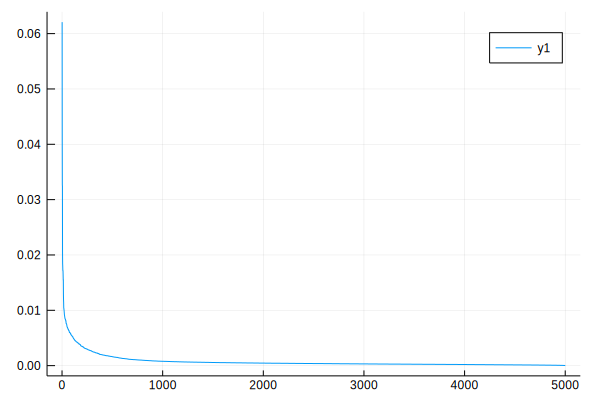

In [7]:
x = collect(1:sol.N_mc)
plot(x[1:end],fdist[1:end])

In [8]:
db_eps = 0.15
db_res = dbscan(D,db_eps,k)

DbscanResult([1, 1986], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2, 2, 2, 2, 2, 2, 1, 2, 2, 2], [2659, 2341])

In [9]:
cluster_n_noise(db_res)

0

In [10]:
cluster_members = cluster_membership(cmcbb,db_res,0.05,0.01, min_members=1);

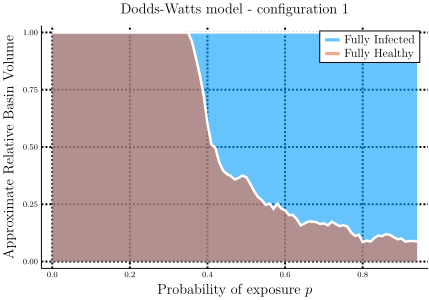

In [11]:
Plots.pgfplots()
Plots.plot(cluster_members, linecolor="white", fillalpha=0.6, guidefontsize= 14, legendfontsize=12, labels=["Fully Infected","Fully Healthy"], xlabel=[L"Probability of exposure $p$"], title="Dodds-Watts model - configuration 1")


In [12]:
Plots.savefig("dw-1-cm.pdf")

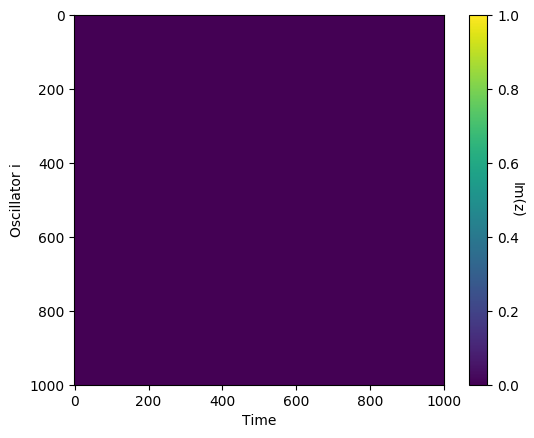

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[13]:14
└ @ Core In[13]:14
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[13]:14
└ @ Core In[13]:14


PyObject Text(524.5605555555557, 0.5, 'Im(z)')

In [13]:
function convert_to_numbers(arr_in::AbstractArray)
    arr_out = zeros(Int,size(arr_in))
    arr_out[arr_in .== 's'] .= 0
    arr_out[arr_in .== 'i'] .= 1
    arr_out[arr_in .== 'r'] .= 2
    return arr_out
end
example_sol = get_trajectory(cmcbb, sol, db_res, 2).sol
example_traj = convert_to_numbers(example_sol)
IM = PyPlot.imshow(example_traj)
PyPlot.ylabel("Oscillator i")
PyPlot.xlabel("Time")
cb = PyPlot.colorbar(IM)
cb[:ax][:set_ylabel]("Im(z)", rotation=270)

# Other Config 

Configuration for more complex stability landscape

Dose Threshold Distribution $g(d) = 0.075δ(d − 1) + 0.4δ(d − 2) + 0.525δ(d − 12)$

In [14]:
T = 20. 
r = 1.
function threshold_dist_1()
    p = rand()
    if p < 0.075
        return 1.
    elseif p < 0.4075
        return 2.
    else
        return 12.
    end
end

pars2 = dodds_watts_parameters(N, 0.5, T, r, rho, threshold_dist_1)
cp2 = CustomProblem(dodds_watts_prob, dodds_watts_ic(), (1,Int(1e3)), pars)
cmcbb2 = CustomMCBBProblem(cp, dodds_watts_ic, N_ics, pars2, (:p, p_gen), eval_run_dw, tail_frac);      

In [15]:
a=zeros(10000)
for i=1:10000
    a[i]=threshold_dist_1()
end
hist(a,bins=100);
title("Threshold Distribution g")

UndefVarError: UndefVarError: hist not defined

In [16]:
if !LOAD
    println("solving....")
    sol2 = solve(cmcbb2);
    @save "dodds-watts-config2.jld2" cmcbb2 sol2 
else 
    println("loading....")
    @load "dodds-watts-config2.jld2" cmcbb2 sol2 
end 

loading....


2-element Array{Symbol,1}:
 :cmcbb2
 :sol2  

In [17]:
D2 = distance_matrix(sol2, cmcbb2, [1., 1., 0.], histograms=true);
k = 4
fdist = k_dist(D2,k);

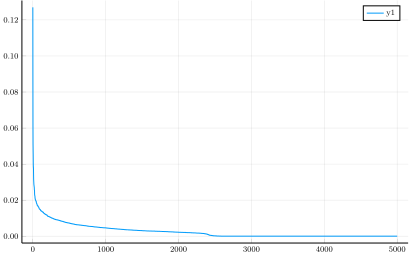

In [18]:
x = collect(1:sol2.N_mc)
plot(x[1:end],fdist[1:end])

In [19]:
db_eps2 = 0.15
db_res2 = dbscan(D2,db_eps2,20)

DbscanResult([1, 1668, 3749], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [1905, 2332, 763])

In [20]:
cluster_n_noise(db_res2)

0

In [21]:
cluster_members = cluster_membership(cmcbb2,db_res2,0.05,0.01, min_members=1);

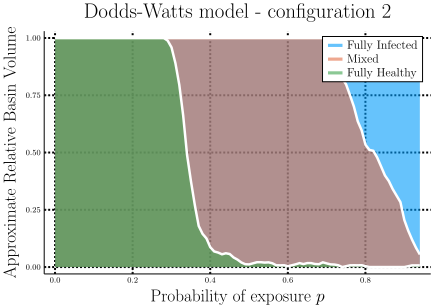

In [23]:
Plots.pgfplots()
Plots.plot(cluster_members, linecolor="white", fillalpha=0.6, guidefontsize= 18, legendfontsize=12, titlefontsize=22, labels=[ "Fully Infected", "Mixed","Fully Healthy"], xlabel=[L"Probability of exposure $p$"], title="Dodds-Watts model - configuration 2")


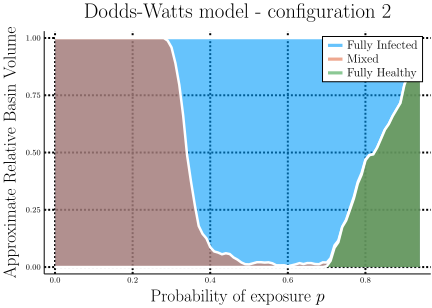

In [24]:
sort!(cluster_members)
Plots.plot(cluster_members, linecolor="white", fillalpha=0.6, guidefontsize= 18, legendfontsize=12, titlefontsize=22, labels=[ "Fully Infected", "Mixed","Fully Healthy"], xlabel=[L"Probability of exposure $p$"], title="Dodds-Watts model - configuration 2")


In [36]:
cluster_members[:,1] = cluster_members[:,2]

ArgumentError: ArgumentError: invalid index: (Colon(), 1) of type Tuple{Colon,Int64}

In [25]:
Plots.savefig("dw-2-cm.pdf")

In [26]:
colororder = ["blue","orange","green","red","purple","brown","magenta","olive","cyan"]
measure_1 = 1
measure_2 = 2

m1m = cluster_measure_mean(sol2, db_res2, measure_1)
m1sd = cluster_measure_std(sol2, db_res2, measure_1)
m2m = cluster_measure_mean(sol2, db_res2, measure_2)
m2sd = cluster_measure_std(sol2, db_res2, measure_2)

SC = scatter(m1m[2:end], m2m[2:end], c=colororder[1:length(m1m)-1])
errorbar(m1m[2:end], m2m[2:end], fmt="o", ms=0,ecolor=colororder[1:length(m1m)-1], xerr=m1sd[2:end], yerr=m2sd[2:end])
#legend()
#legend(lp, ("Outlier","2","3","4","5","6","7","8","9","10","11"))
xlabel("Average Fraction of S", fontsize=20)
ylabel("Average Fraction of I", fontsize=20)
title("Average Measures of the Clusters", fontsize=20)
savefig("average-cluster-dw.pdf")

UndefVarError: UndefVarError: errorbar not defined

In [28]:
(example_sol, probi, isol) = get_trajectory(cmcbb2, sol2, db_res2, 3, only_sol=false)
example_traj = convert_to_numbers(example_sol.sol)
IM = imshow(example_traj[:,:])
ylabel(L"Individual $i$",fontsize=20)
xlabel(L"Time $t$", fontsize=20)
title("Example trajectory Cluster 2",fontsize=20)
savefig("dw-example-traj")
#cb = colorbar(IM)
#cb[:ax][:set_ylabel](, rotation=270)

UndefVarError: UndefVarError: imshow not defined

In [30]:
i_meas = 2
shists = cluster_measures_sliding_histograms(cmcbb2, sol2, db_res2, i_meas, 0.05, 0.01);
measure_names = ["Fraction of S",L"Fraction of $I$"];
clabels = ["Outlier","Fully Healthy","Mixed","Fully Infected"]

4-element Array{String,1}:
 "Outlier"       
 "Fully Healthy" 
 "Mixed"         
 "Fully Infected"

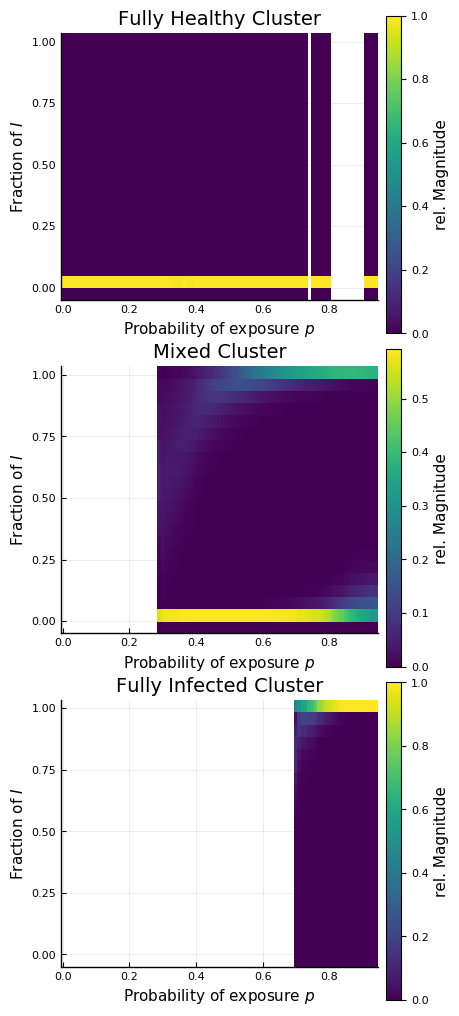

In [31]:
l = @layout [a; b; c]
Plots.pyplot()
# double check: titles/clusters could change orders 
p2 = Plots.plot(shists, 2, c=:viridis, title=string(clabels[2] ," Cluster"), xlabel=L"Probability of exposure $p$", ylabel=measure_names[2])
p3 = Plots.plot(shists, 3, c=:viridis, title=string(clabels[3] ," Cluster"), xlabel=L"Probability of exposure $p$", ylabel=measure_names[2])
p4 = Plots.plot(shists, 4, c=:viridis, title=string(clabels[4] ," Cluster"), xlabel=L"Probability of exposure $p$", ylabel=measure_names[2])


Plots.plot(p2, p3, p4, layout = l, size=(450,1000))
Plots.savefig("dw-2-hists.pdf")

In [32]:
cmr = cluster_measures(cmcbb2, sol2, db_res2, 0.05, 0.01);

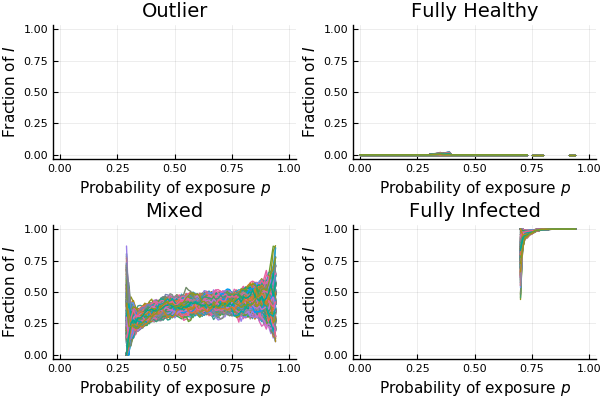

In [33]:
#fig = figure(figsize=(10,10))
xlimits = [0,1];
ylimits_means = [0,1];
plotis = []
for (i,j) in enumerate(1:4)
    #subplot(4,2,i)
   # plot(cmr.par, collect(cmr.cluster_measures[i,6,:,:]'), alpha=0.5);
    #plot(p_win, collect(cluster_measures_global[i,1,:,:]'), alpha=0.5);
    push!(plotis, Plots.plot(cmr, 2, j, xlims=xlimits, ylims=ylimits_means, title=clabels[i], ylabel=measure_names[2], xlabel=L"Probability of exposure $p$"))
    #xlim(xlimits[1],xlimits[2]);
    #ylim(ylimits_means[1],ylimits_means[2]);
end


Plots.plot(plotis...)